# What to do with videos?

* <u>Motivation</u>

After playing with the 4 first image puzzles (see my first Notebook [here](https://www.aicrowd.com/showcase/learn-from-started-code), with around 99% accuracy submissions)), it's time to face the last (but not least) puzzle about **video transcription**.

As it's a new field for me, I started some web researches, and here is where I am. One direction I found is to **capture several images from each video**, and analyse these images. 

--> Could this bring back us to **image model?**

--> Could I use the **FEN Notation** transcription model to compare pictures?

* <u> Context </u>

We have access to short video (around 1 seconde) of a chessboard with some moving pieces (around 4-8 moves). The objective is to **translate the moves** from each video.

* <u>AICrowd connexion 🔌</u>

In [ ]:
## - connect
!pip install --upgrade fastai git+https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli.git >/dev/null
%load_ext aicrowd.magic

API_KEY = 'b46152c118edae059e08ebd1f8ada78f'
%aicrowd login --api-key $API_KEY

  Running command git clone -q https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli.git /tmp/pip-req-build-1qngctlj
API Key valid
Saved API Key successfully!


### Import Packages 📦

In [ ]:
## - librairies
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
import string

# for model building
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from skimage import io, transform
from skimage.util.shape import view_as_blocks

### Access Data ♚♕♜♘♝♙

In [ ]:
## - data
%aicrowd dataset download --challenge chess-transcription -j 3

!mkdir data
!mkdir data/video
!unzip train.zip  -d data/video/ 
!unzip val.zip -d data/video/ 
!unzip test.zip  -d data/video/ 

!mv train.zip data/video/train.zip
!mv train.csv data/video/train.csv
!mv val.csv data/video/val.csv
!mv val.zip data/video/val.zip
!mv test.zip data/video/test.zip
!mv sample_submission.csv data/video/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: data/video/train/3313.mp4  
  inflating: data/video/train/1414.mp4  
  inflating: data/video/train/1784.mp4  
  inflating: data/video/train/4752.mp4  
  inflating: data/video/train/2678.mp4  
  inflating: data/video/train/4619.mp4  
  inflating: data/video/train/3463.mp4  
  inflating: data/video/train/910.mp4  
  inflating: data/video/train/3481.mp4  
  inflating: data/video/train/4900.mp4  
  inflating: data/video/train/4671.mp4  
  inflating: data/video/train/1689.mp4  
  inflating: data/video/train/4035.mp4  
  inflating: data/video/train/2598.mp4  
  inflating: data/video/train/2900.mp4  
  inflating: data/video/train/1273.mp4  
  inflating: data/video/train/3977.mp4  
  inflating: data/video/train/4051.mp4  
  inflating: data/video/train/2040.mp4  
  inflating: data/video/train/1140.mp4  
  inflating: data/video/train/2754.mp4  
  inflating: data/video/train/3385.mp4  
  inflating: data/video/train/4204.mp4  
  infla

In [ ]:
video_df = pd.read_csv("data/video/train.csv")
video_df['VideoID'] = video_df['VideoID'].astype(str)+".mp4"
video_df

,VideoID,label
0,0.mp4,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2
1,1.mp4,c2b3 e1f1 f7e7 a3a4 e7e3 a4a5
2,2.mp4,f1c1 h6h7 h4f3 h2g4 f6g6 g4f6 c1g1 f6d7 g6f5
3,3.mp4,h4h5 a7b5 c4b2 d7e6 g1h3 h6f7
4,4.mp4,c6g6 b1c2 g6g5 a2b2 h4f5 e4d3
...,...,...
4995,4995.mp4,f2e1 b5b8 d1d2 c5c4 d2e2 b8b4
4996,4996.mp4,c7e6 h8b2 d5d4 c4c3 d4e4 c3d2 c8a7 h4g2 b6c6
4997,4997.mp4,g4e5 c5b4 f5b1 b4a5 b6a5 e3e4 g5h4 c4e5 h4g3
4998,4998.mp4,h7h5 h1e1 h8a8 e3d2 e7f7 a4a6 a8f8 e5f7


In [ ]:
video_dftest = pd.read_csv("data/video/sample_submission.csv")
video_dftest['VideoID'] = video_dftest['VideoID'].astype(str)+".mp4"
video_dftest['label'] = ''
video_dftest

,VideoID,label
0,0.mp4,
1,1.mp4,
2,2.mp4,
3,3.mp4,
4,4.mp4,
...,...,...
1995,1995.mp4,
1996,1996.mp4,
1997,1997.mp4,
1998,1998.mp4,


### From video to images 🎥📸

The aim is to transform the video into several images, as I should be easier to analysis these new images than the video itself. Most of the time, a movie contains 24 images per second of video. It could too much for this problem, maybe only 5 images could be enough.

For a starting point, we will try to decompose each video into 2 pictures (stored in a new folder), one at the beginning of the video, and a second at the end. A same label, the one of the original video, will be display for each image associated.

In [ ]:
!rm -rf data/video/train_frame
!mkdir data/video/train_frame

In [ ]:
for i in tqdm(range(8)):
#for i in tqdm(range(video_df.shape[0])):
  count = 0
  videoFile = video_df['VideoID'][i]
  cap = cv2.VideoCapture('data/video/train/' + videoFile)  # capturing the video from the given path
  frameRate = 2 #cap.get(5)                                   # frame rate
  x = 1
  while(cap.isOpened()):
      frameId = cap.get(1)                                 # current frame number
      ret, frame = cap.read()
      if (ret != True):
          print ('break')
          break
      if (frameId % math.floor(frameRate) == 0):
          print ('store')
          filename ='data/video/train_frame/' + videoFile + "_frame%d.jpg" % count;count+=1
          cv2.imwrite(filename, frame)                      # storing the frames
  cap.release()

print ("Done!")

 12%|█▎        | 1/8 [00:00<00:02,  3.47it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


100%|██████████| 8/8 [00:00<00:00, 13.51it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
break
Done!


Let's have a look at images resulting of the first video: we have now the start and the end view of the video. Could be enough to understand moves? I think so.

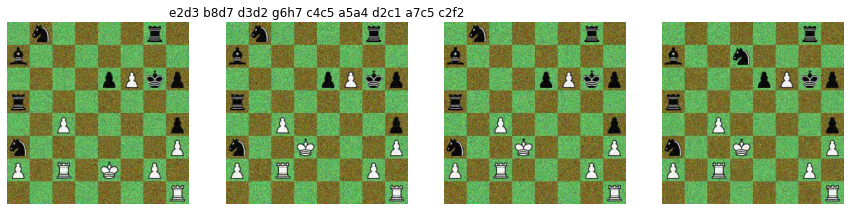

In [ ]:
f, axarr = plt.subplots(1,4, figsize=(15, 15))

for i in range(0,4):
  if(i == 1):
    axarr[i].set_title(video_df['label'][0], fontsize=12, pad=5)
  else:
    axarr[i].set_title('')
  axarr[i].imshow(mpimg.imread('data/video/train_frame/0.mp4_frame' + str(i) + '.jpg'))
  axarr[i].axis('off')

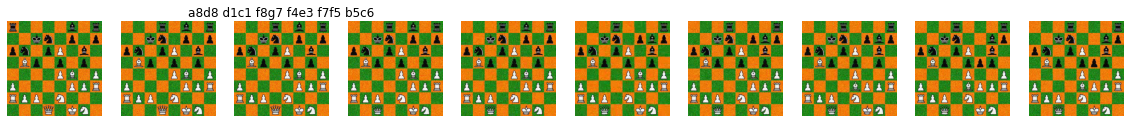

In [ ]:
f, axarr = plt.subplots(1,10, figsize=(20, 20))

for i in range(0,10):
  if(i == 2):
    axarr[i].set_title(video_df['label'][7], fontsize=12, pad=5)
  else:
    axarr[i].set_title('')
  axarr[i].imshow(mpimg.imread('data/video/train_frame/7.mp4_frame' + str(i) + '.jpg'))
  axarr[i].axis('off')

In order to associate the right label with the corresponding images, we create a new train dataset.

In [ ]:
# - getting the names of all the images
images = glob("data/video/train_frame/*.jpg")
video_name = []
image_name = []
frame_number = []
video_label = []

for i in tqdm(range(len(images))):
    # - creating the image name
    imageName = images[i].split('/')[3]
    image_name.append(imageName)
    # - creating the image label
    videoName = images[i].split('/')[3].split('_')[0]
    video_name.append(videoName)
    frameNb = images[i].split('/')[3].split('_')[1].split('.')[0][5:]
    frameNb = int(frameNb)
    frame_number.append(frameNb)
    videoLabel = video_df[video_df['VideoID'] == videoName]['label'].iloc[0]
    video_label.append(videoLabel)

# - storing the images and their class in a dataframe
image_df = pd.DataFrame()
image_df['VideoID'] = video_name
image_df['frame'] = frame_number
image_df['ImageID'] = image_name
image_df['label'] = video_label

# - converting the dataframe into csv file 
image_df.to_csv('data/video/image_df.csv', header = True, index = False)

image_df = image_df.sort_values(['VideoID', 'frame'])
image_df.index = range(image_df.shape[0])
image_df

100%|██████████| 91/91 [00:00<00:00, 1247.16it/s]


,VideoID,frame,ImageID,label
0,0.mp4,0,0.mp4_frame0.jpg,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2
1,0.mp4,1,0.mp4_frame1.jpg,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2
2,0.mp4,2,0.mp4_frame2.jpg,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2
3,0.mp4,3,0.mp4_frame3.jpg,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2
4,0.mp4,4,0.mp4_frame4.jpg,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2
...,...,...,...,...
86,7.mp4,5,7.mp4_frame5.jpg,a8d8 d1c1 f8g7 f4e3 f7f5 b5c6
87,7.mp4,6,7.mp4_frame6.jpg,a8d8 d1c1 f8g7 f4e3 f7f5 b5c6
88,7.mp4,7,7.mp4_frame7.jpg,a8d8 d1c1 f8g7 f4e3 f7f5 b5c6
89,7.mp4,8,7.mp4_frame8.jpg,a8d8 d1c1 f8g7 f4e3 f7f5 b5c6


### Training 💪

The solution is not explored yet.

In [ ]:
## creating an empty list
#train_images = []

## for loop to read and store frames
#for i in tqdm(range(image_df.shape[0])):
#    # loading the image and keeping the target size as (224,224,3)
#    img = image.load_img('data/video/train_frame/' + image_df['ImageID'][i], target_size=(224,224,3))
#    # converting it to array
#    img = image.img_to_array(img)
#    # normalizing the pixel value
#    img = img/255
#    # appending the image to the train_image list
#    train_images.append(img)
#    
#train_array = np.array(train_images)
#train_array.shape

### FEN Notation 📝

I already developed a model (3rd puzzle of this challenge) to translate a chessboard image to its **FEN Notation**. One solution could be to **compare the FEN Notations of 2 pictures** from the same video, and build a quite complex function to identify required moves to go from one notation to the second.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # load json and create model
# json_file = open('FEN_model.json', 'r')
# FEN_model_json = json_file.read()
# json_file.close()
# FEN_model = keras.models.model_from_json(FEN_model_json)
# # load weights into new model
# FEN_model.load_weights("FEN_model.h5")
from keras.models import Sequential, load_model

FEN_model = load_model('/content/drive/MyDrive/FENGenerator_model')
print("Loaded FEN model from disk")

Loaded FEN model from disk


Translate FEN Notation from new images

In [ ]:
def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

By applying the FEN model, we create an array of 64 values (one for each case of the chessboard), and this for each image. We already developped a function to translate this array into a FEN Notation. But for the purpose of this challenge (translate moves), we should developped a new function.

--> How build a function that **compare 2 successive** arrays, detect difference and associate it to a move?

In [ ]:
path1 = 'data/video/train_frame/' + image_df['ImageID'][0]
oh1 = FEN_model.predict(process_image(path1)).argmax(axis=1).reshape(-1, 8, 8)[0]
oh1

array([[12,  3, 12, 12, 12, 12,  1, 12],
       [ 2, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12, 12,  0,  6,  4,  0],
       [ 1, 12, 12, 12, 12, 12, 12, 12],
       [12, 12,  6, 12, 12, 12, 12,  0],
       [ 3, 12, 12, 12, 12, 12, 12,  6],
       [ 6, 12,  7, 12, 10, 12,  6, 12],
       [12, 12, 12, 12, 12, 12, 12,  7]])

In [ ]:
path2 = 'data/video/train_frame/' + image_df['ImageID'][1]
oh2 = FEN_model.predict(process_image(path2)).argmax(axis=1).reshape(-1, 8, 8)[0]
oh2

array([[12,  3, 12, 12, 12, 12,  1, 12],
       [ 2, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12, 12,  0,  6,  4,  0],
       [ 1, 12, 12, 12, 12, 12, 12, 12],
       [12, 12,  6, 12, 12, 12, 12,  0],
       [ 3, 12, 12, 10, 12, 12, 12,  6],
       [ 6, 12,  7, 12, 12, 12,  6, 12],
       [12, 12, 12, 12, 12, 12, 12,  7]])

In [ ]:
def move_from_2onehots(oh1, oh2):
    case = ''
    for j in range(8):
        for i in range(8):
            if(oh1[j][i] != oh2[j][i]):
                case += 'abcdefgh'[i] + str(8-j)
    
    if(case == ''):
      #print('no move')
      return case

    if(oh2[8-int(case[1])][string.ascii_lowercase.index(case[0])] != 12):
      output = case[2:] + case[:2]
    else:
      output = case

    return output

move_from_2onehots(oh1, oh2)

'e2d3'

In [ ]:
train_moves = []

for i in tqdm(range(image_df.shape[0]-1)):

    if(image_df['ImageID'][i].split('_')[0] == image_df['ImageID'][i+1].split('_')[0]):
        path1 = 'data/video/train_frame/'+ image_df['ImageID'][i]
        #print(path1)
        oh1 = FEN_model.predict(process_image(path1)).argmax(axis=1).reshape(-1, 8, 8)[0]

        path2 = 'data/video/train_frame/'+ image_df['ImageID'][i+1]
        #print(path2)
        oh2 = FEN_model.predict(process_image(path2)).argmax(axis=1).reshape(-1, 8, 8)[0]

        detected_move = move_from_2onehots(oh1, oh2)
        print(detected_move)
        train_moves.append(detected_move)
    
    else:
        train_moves.append('')

train_moves.append('')

  2%|▏         | 2/90 [00:00<00:20,  4.35it/s]

e2d3



  3%|▎         | 3/90 [00:00<00:19,  4.42it/s]

b8d7


  4%|▍         | 4/90 [00:00<00:19,  4.35it/s]

  7%|▋         | 6/90 [00:01<00:18,  4.49it/s]

d3d2



  8%|▊         | 7/90 [00:01<00:18,  4.41it/s]

g6h7


 10%|█         | 9/90 [00:01<00:17,  4.70it/s]


c4c5


 11%|█         | 10/90 [00:02<00:17,  4.70it/s]

a5a4


 12%|█▏        | 11/90 [00:02<00:16,  4.77it/s]

d2c1


 13%|█▎        | 12/90 [00:02<00:16,  4.69it/s]

a7c5


 14%|█▍        | 13/90 [00:02<00:16,  4.68it/s]

c2f2


 17%|█▋        | 15/90 [00:03<00:13,  5.48it/s]

 18%|█▊        | 16/90 [00:03<00:14,  5.01it/s]

c2b3


 19%|█▉        | 17/90 [00:03<00:15,  4.74it/s]

e1f1


 20%|██        | 18/90 [00:03<00:15,  4.65it/s]

 21%|██        | 19/90 [00:03<00:15,  4.57it/s]

f7e7


 22%|██▏       | 20/90 [00:04<00:15,  4.44it/s]

 23%|██▎       | 21/90 [00:04<00:16,  4.31it/s]

a3a4


 26%|██▌       | 23/90 [00:04<00:14,  4.59it/s]

e7e3



 27%|██▋       | 24/90 [00:05<00:14,  4.59it/s]

a4a5


 29%|██▉       | 26/90 [00:05<00:12,  5.28it/s]

 30%|███       | 27/90 [00:05<00:12,  5.03it/s]

f1c1


 31%|███       | 28/90 [00:05<00:12,  4.83it/s]

 32%|███▏      | 29/90 [00:05<00:12,  4.83it/s]

h6h7


 33%|███▎      | 30/90 [00:06<00:13,  4.60it/s]

 34%|███▍      | 31/90 [00:06<00:13,  4.48it/s]

h4f3


 36%|███▌      | 32/90 [00:06<00:13,  4.44it/s]

h2g4


 37%|███▋      | 33/90 [00:06<00:12,  4.45it/s]

f6g6


 38%|███▊      | 34/90 [00:07<00:15,  3.72it/s]

g4f6


 39%|███▉      | 35/90 [00:07<00:16,  3.33it/s]

 40%|████      | 36/90 [00:08<00:18,  2.99it/s]

c1g1


 41%|████      | 37/90 [00:08<00:18,  2.84it/s]

f6d7


 42%|████▏     | 38/90 [00:08<00:19,  2.73it/s]

 43%|████▎     | 39/90 [00:09<00:20,  2.54it/s]

g6f5


 46%|████▌     | 41/90 [00:09<00:17,  2.84it/s]

 47%|████▋     | 42/90 [00:10<00:17,  2.71it/s]

h4h5


 48%|████▊     | 43/90 [00:10<00:19,  2.45it/s]

a7b5


 49%|████▉     | 44/90 [00:11<00:19,  2.30it/s]

 50%|█████     | 45/90 [00:11<00:20,  2.20it/s]

c4b2


 51%|█████     | 46/90 [00:12<00:20,  2.14it/s]

 52%|█████▏    | 47/90 [00:12<00:19,  2.16it/s]

d7e6


 53%|█████▎    | 48/90 [00:13<00:20,  2.10it/s]

g1h3


 56%|█████▌    | 50/90 [00:13<00:16,  2.48it/s]

 57%|█████▋    | 51/90 [00:14<00:15,  2.47it/s]

c6g6


 58%|█████▊    | 52/90 [00:14<00:16,  2.28it/s]

 59%|█████▉    | 53/90 [00:15<00:16,  2.31it/s]

b1c2


 60%|██████    | 54/90 [00:15<00:14,  2.45it/s]

g6g5


 61%|██████    | 55/90 [00:15<00:12,  2.84it/s]

 62%|██████▏   | 56/90 [00:15<00:10,  3.22it/s]

a2b2


 63%|██████▎   | 57/90 [00:16<00:09,  3.47it/s]

h4f5


 64%|██████▍   | 58/90 [00:16<00:08,  3.63it/s]

e4d3


 67%|██████▋   | 60/90 [00:16<00:06,  4.43it/s]

 68%|██████▊   | 61/90 [00:16<00:06,  4.38it/s]

f1e1


 69%|██████▉   | 62/90 [00:16<00:06,  4.30it/s]

a8e8


 70%|███████   | 63/90 [00:17<00:06,  4.23it/s]

e1f1


 71%|███████   | 64/90 [00:17<00:06,  4.19it/s]

c5d3


 72%|███████▏  | 65/90 [00:17<00:05,  4.23it/s]

 73%|███████▎  | 66/90 [00:17<00:05,  4.24it/s]

b1b5


 74%|███████▍  | 67/90 [00:18<00:05,  4.26it/s]

f8e7


 76%|███████▌  | 68/90 [00:18<00:04,  4.42it/s]

 78%|███████▊  | 70/90 [00:18<00:03,  5.23it/s]

a3a1


 79%|███████▉  | 71/90 [00:18<00:03,  4.91it/s]

 81%|████████  | 73/90 [00:19<00:03,  4.75it/s]

f8f7
a1f1


 82%|████████▏ | 74/90 [00:19<00:03,  4.71it/s]

 83%|████████▎ | 75/90 [00:19<00:03,  4.29it/s]

e7c7


 84%|████████▍ | 76/90 [00:19<00:03,  4.39it/s]

f2e3


 86%|████████▌ | 77/90 [00:20<00:02,  4.38it/s]

e5f6


 87%|████████▋ | 78/90 [00:20<00:02,  4.35it/s]

f1c1


 88%|████████▊ | 79/90 [00:20<00:02,  4.27it/s]

 89%|████████▉ | 80/90 [00:20<00:02,  4.36it/s]

f6c3


 91%|█████████ | 82/90 [00:21<00:01,  5.16it/s]

a8d8


 92%|█████████▏| 83/90 [00:21<00:01,  4.86it/s]

 93%|█████████▎| 84/90 [00:21<00:01,  4.61it/s]

d1c1


 94%|█████████▍| 85/90 [00:21<00:01,  4.56it/s]

 96%|█████████▌| 86/90 [00:22<00:00,  4.61it/s]

f8g7


 97%|█████████▋| 87/90 [00:22<00:00,  4.48it/s]

 98%|█████████▊| 88/90 [00:22<00:00,  4.38it/s]

f4e3


 99%|█████████▉| 89/90 [00:22<00:00,  4.39it/s]

f7f5


100%|██████████| 90/90 [00:22<00:00,  3.91it/s]

In [ ]:
image_df['moves'] = train_moves
image_df

,VideoID,frame,ImageID,label,moves
0,0.mp4,0,0.mp4_frame0.jpg,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2,e2d3
1,0.mp4,1,0.mp4_frame1.jpg,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2,
2,0.mp4,2,0.mp4_frame2.jpg,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2,b8d7
3,0.mp4,3,0.mp4_frame3.jpg,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2,
4,0.mp4,4,0.mp4_frame4.jpg,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2,d3d2
...,...,...,...,...,...
86,7.mp4,5,7.mp4_frame5.jpg,a8d8 d1c1 f8g7 f4e3 f7f5 b5c6,
87,7.mp4,6,7.mp4_frame6.jpg,a8d8 d1c1 f8g7 f4e3 f7f5 b5c6,f4e3
88,7.mp4,7,7.mp4_frame7.jpg,a8d8 d1c1 f8g7 f4e3 f7f5 b5c6,f7f5
89,7.mp4,8,7.mp4_frame8.jpg,a8d8 d1c1 f8g7 f4e3 f7f5 b5c6,


In [ ]:
video_moves = []

output = image_df['moves'][0]
print(output)
for i in tqdm(range(image_df.shape[0]-1)):
    if(image_df['VideoID'][i+1] == image_df['VideoID'][i]):
      if(image_df['moves'][i+1] != ''):
        output += ' '
        output += image_df['moves'][i+1]
        #print(output)
    else:
      video_moves.append(output)
      output = output = image_df['moves'][i+1]
video_moves.append(output)

video_moves

100%|██████████| 90/90 [00:00<00:00, 29312.58it/s]

e2d3


['e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2',
 ' c2b3 e1f1 f7e7 a3a4 e7e3 a4a5',
 ' f1c1 h6h7 h4f3 h2g4 f6g6 g4f6 c1g1 f6d7 g6f5',
 ' h4h5 a7b5 c4b2 d7e6 g1h3',
 ' c6g6 b1c2 g6g5 a2b2 h4f5 e4d3',
 ' f1e1 a8e8 e1f1 c5d3 b1b5 f8e7',
 'a3a1 f8f7 a1f1 e7c7 f2e3 e5f6 f1c1 f6c3',
 'a8d8 d1c1 f8g7 f4e3 f7f5']

In [ ]:
video_df.head(n = 8)

,VideoID,label
0,0.mp4,e2d3 b8d7 d3d2 g6h7 c4c5 a5a4 d2c1 a7c5 c2f2
1,1.mp4,c2b3 e1f1 f7e7 a3a4 e7e3 a4a5
2,2.mp4,f1c1 h6h7 h4f3 h2g4 f6g6 g4f6 c1g1 f6d7 g6f5
3,3.mp4,h4h5 a7b5 c4b2 d7e6 g1h3 h6f7
4,4.mp4,c6g6 b1c2 g6g5 a2b2 h4f5 e4d3
5,5.mp4,f1e1 a8e8 e1f1 c5d3 b1b5 f8e7 f1c1
6,6.mp4,a3a1 f8f7 a1f1 e7c7 f2e3 e5f6 f1c1 f6c3 b3c3
7,7.mp4,a8d8 d1c1 f8g7 f4e3 f7f5 b5c6


It seems to work, but not perfectly, as I missed sometimes the last moves! It's due to images, I don't know why, but sometimes I didn't capture the last view of the video. Maybe I will have to increase the number of frames. Let's try to make a submission with this.

### Apply to test dataset

In [ ]:
!rm -rf data/video/test_frame
!mkdir data/video/test_frame

In [ ]:
for i in tqdm(range(video_dftest.shape[0])):
  count = 0
  videoFile = video_dftest['VideoID'][i]
  cap = cv2.VideoCapture('data/video/test/' + videoFile)  # capturing the video from the given path
  frameRate = 1                                           # frame rate
  x = 1
  while(cap.isOpened()):
      frameId = cap.get(1)                                 # current frame number
      ret, frame = cap.read()
      if (ret != True):
          print ('break')
          break
      if (frameId % math.floor(frameRate) == 0):
          print ('store')
          filename ='data/video/test_frame/' + videoFile + "_frame%d.jpg" % count;count+=1
          cv2.imwrite(filename, frame)                      # storing the frames
  cap.release()

print ("Done!")

  0%|          | 2/2000 [00:00<02:10, 15.35it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store

  0%|          | 4/2000 [00:00<02:10, 15.30it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  0%|          | 8/2000 [00:00<02:25, 13.65it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


  0%|          | 10/2000 [00:00<02:22, 14.00it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


  1%|          | 14/2000 [00:00<02:09, 15.36it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


  1%|          | 16/2000 [00:01<02:10, 15.16it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  1%|          | 20/2000 [00:01<02:10, 15.16it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


  1%|          | 24/2000 [00:01<02:04, 15.82it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


  1%|▏         | 26/2000 [00:01<02:09, 15.19it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


  2%|▏         | 30/2000 [00:02<02:12, 14.83it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


  2%|▏         | 32/2000 [00:02<02:18, 14.26it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


  2%|▏         | 34/2000 [00:02<02:07, 15.46it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


  2%|▏         | 39/2000 [00:02<02:05, 15.63it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  2%|▏         | 41/2000 [00:02<02:12, 14.76it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  2%|▏         | 45/2000 [00:03<02:15, 14.46it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


  2%|▏         | 47/2000 [00:03<02:17, 14.17it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  3%|▎         | 51/2000 [00:03<02:10, 14.92it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  3%|▎         | 53/2000 [00:03<02:12, 14.65it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


  3%|▎         | 57/2000 [00:03<02:05, 15.45it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  3%|▎         | 59/2000 [00:03<02:16, 14.25it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


  3%|▎         | 64/2000 [00:04<02:08, 15.05it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


  3%|▎         | 66/2000 [00:04<02:09, 14.97it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  4%|▎         | 70/2000 [00:04<02:04, 15.53it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  4%|▎         | 74/2000 [00:04<02:01, 15.87it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


  4%|▍         | 76/2000 [00:05<01:59, 16.06it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  4%|▍         | 80/2000 [00:05<01:56, 16.50it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  4%|▍         | 82/2000 [00:05<01:59, 16.01it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  4%|▍         | 86/2000 [00:05<02:10, 14.61it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


  4%|▍         | 88/2000 [00:05<02:08, 14.82it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  5%|▍         | 92/2000 [00:06<02:09, 14.73it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  5%|▍         | 94/2000 [00:06<02:14, 14.17it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


  5%|▍         | 96/2000 [00:06<02:19, 13.61it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  5%|▌         | 101/2000 [00:06<02:19, 13.60it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


  5%|▌         | 103/2000 [00:06<02:24, 13.09it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  5%|▌         | 108/2000 [00:07<01:58, 16.03it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


  6%|▌         | 110/2000 [00:07<02:10, 14.51it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  6%|▌         | 112/2000 [00:07<02:14, 14.05it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  6%|▌         | 116/2000 [00:07<01:58, 15.89it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


  6%|▌         | 120/2000 [00:07<01:57, 16.01it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


  6%|▌         | 122/2000 [00:08<01:55, 16.26it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

  6%|▋         | 126/2000 [00:08<02:06, 14.84it/s]


store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


  6%|▋         | 128/2000 [00:08<02:00, 15.52it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  7%|▋         | 132/2000 [00:08<01:54, 16.28it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


  7%|▋         | 136/2000 [00:08<01:57, 15.83it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


  7%|▋         | 138/2000 [00:09<01:57, 15.80it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


  7%|▋         | 142/2000 [00:09<02:00, 15.43it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  7%|▋         | 144/2000 [00:09<01:59, 15.56it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

  7%|▋         | 146/2000 [00:09<02:20, 13.23it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store

  8%|▊         | 150/2000 [00:10<02:18, 13.34it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


  8%|▊         | 152/2000 [00:10<02:18, 13.30it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


  8%|▊         | 156/2000 [00:10<02:11, 14.05it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


  8%|▊         | 160/2000 [00:10<01:55, 15.90it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


  8%|▊         | 162/2000 [00:10<01:51, 16.51it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


  8%|▊         | 166/2000 [00:11<01:52, 16.36it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  8%|▊         | 168/2000 [00:11<01:51, 16.42it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  9%|▊         | 172/2000 [00:11<01:55, 15.79it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


  9%|▉         | 176/2000 [00:11<01:52, 16.25it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


  9%|▉         | 178/2000 [00:11<01:51, 16.32it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  9%|▉         | 182/2000 [00:12<02:00, 15.04it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


  9%|▉         | 186/2000 [00:12<01:52, 16.07it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


  9%|▉         | 188/2000 [00:12<01:52, 16.14it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 10%|▉         | 192/2000 [00:12<01:57, 15.35it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 10%|▉         | 194/2000 [00:12<02:00, 14.96it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 10%|▉         | 198/2000 [00:13<01:54, 15.79it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 10%|█         | 200/2000 [00:13<01:53, 15.82it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 10%|█         | 205/2000 [00:13<01:49, 16.38it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 10%|█         | 207/2000 [00:13<01:48, 16.52it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 11%|█         | 211/2000 [00:13<01:54, 15.59it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 11%|█         | 213/2000 [00:14<01:58, 15.12it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 11%|█         | 217/2000 [00:14<01:52, 15.86it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 11%|█         | 221/2000 [00:14<01:52, 15.84it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 11%|█         | 223/2000 [00:14<01:53, 15.73it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 11%|█▏        | 227/2000 [00:14<01:55, 15.38it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 11%|█▏        | 229/2000 [00:15<01:54, 15.40it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 12%|█▏        | 233/2000 [00:15<01:53, 15.50it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 12%|█▏        | 235/2000 [00:15<01:58, 14.90it/s]


store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 12%|█▏        | 239/2000 [00:15<02:05, 14.06it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 12%|█▏        | 241/2000 [00:15<02:02, 14.34it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 12%|█▏        | 245/2000 [00:16<02:02, 14.38it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 12%|█▏        | 247/2000 [00:16<01:58, 14.78it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 13%|█▎        | 251/2000 [00:16<01:47, 16.31it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 13%|█▎        | 255/2000 [00:16<01:45, 16.48it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 13%|█▎        | 257/2000 [00:16<01:48, 16.00it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 13%|█▎        | 261/2000 [00:17<01:44, 16.57it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 13%|█▎        | 265/2000 [00:17<01:51, 15.52it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 13%|█▎        | 267/2000 [00:17<01:49, 15.87it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 14%|█▎        | 271/2000 [00:17<01:48, 15.94it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 14%|█▍        | 275/2000 [00:17<01:39, 17.29it/s]


store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 14%|█▍        | 277/2000 [00:18<01:46, 16.15it/s]


store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 14%|█▍        | 282/2000 [00:18<01:39, 17.24it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 14%|█▍        | 284/2000 [00:18<01:52, 15.26it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 14%|█▍        | 286/2000 [00:18<01:53, 15.14it/s]


store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 14%|█▍        | 290/2000 [00:19<01:58, 14.45it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 15%|█▍        | 292/2000 [00:19<01:59, 14.26it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 15%|█▍        | 296/2000 [00:19<02:01, 14.05it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 15%|█▍        | 298/2000 [00:19<02:06, 13.45it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 15%|█▌        | 300/2000 [00:19<02:07, 13.37it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 15%|█▌        | 304/2000 [00:20<01:59, 14.22it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 15%|█▌        | 306/2000 [00:20<01:55, 14.71it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 16%|█▌        | 310/2000 [00:20<01:53, 14.87it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 16%|█▌        | 314/2000 [00:20<01:53, 14.88it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 16%|█▌        | 316/2000 [00:20<01:53, 14.82it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 16%|█▌        | 318/2000 [00:20<01:56, 14.38it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 16%|█▌        | 323/2000 [00:21<01:53, 14.75it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 16%|█▋        | 325/2000 [00:21<01:55, 14.44it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 16%|█▋        | 327/2000 [00:21<02:04, 13.49it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 17%|█▋        | 331/2000 [00:21<01:58, 14.05it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 17%|█▋        | 333/2000 [00:22<01:55, 14.39it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 17%|█▋        | 337/2000 [00:22<01:40, 16.57it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 17%|█▋        | 341/2000 [00:22<01:47, 15.42it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 17%|█▋        | 344/2000 [00:22<01:42, 16.13it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 17%|█▋        | 348/2000 [00:22<01:39, 16.63it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 18%|█▊        | 352/2000 [00:23<01:38, 16.67it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 18%|█▊        | 354/2000 [00:23<01:35, 17.29it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 18%|█▊        | 358/2000 [00:23<01:45, 15.63it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 18%|█▊        | 360/2000 [00:23<01:49, 14.95it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 18%|█▊        | 364/2000 [00:23<01:47, 15.17it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 18%|█▊        | 366/2000 [00:24<01:48, 15.02it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 18%|█▊        | 370/2000 [00:24<01:55, 14.06it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 19%|█▊        | 372/2000 [00:24<01:52, 14.41it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 19%|█▉        | 376/2000 [00:24<01:56, 14.00it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 19%|█▉        | 378/2000 [00:24<01:54, 14.18it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 19%|█▉        | 382/2000 [00:25<01:45, 15.31it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 19%|█▉        | 386/2000 [00:25<01:38, 16.41it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 19%|█▉        | 388/2000 [00:25<01:36, 16.67it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 20%|█▉        | 392/2000 [00:25<01:50, 14.61it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 20%|█▉        | 394/2000 [00:25<01:46, 15.10it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 20%|█▉        | 398/2000 [00:26<01:46, 15.10it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 20%|██        | 400/2000 [00:26<01:49, 14.57it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 20%|██        | 404/2000 [00:26<01:46, 14.93it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 20%|██        | 406/2000 [00:26<01:49, 14.55it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 20%|██        | 410/2000 [00:27<01:50, 14.40it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 21%|██        | 412/2000 [00:27<01:49, 14.53it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 21%|██        | 414/2000 [00:27<01:56, 13.60it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 21%|██        | 418/2000 [00:27<01:52, 14.02it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 21%|██        | 420/2000 [00:27<01:52, 13.99it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 21%|██        | 424/2000 [00:28<01:51, 14.08it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 21%|██▏       | 428/2000 [00:28<01:40, 15.71it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 22%|██▏       | 430/2000 [00:28<01:48, 14.53it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 22%|██▏       | 432/2000 [00:28<01:57, 13.33it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 22%|██▏       | 434/2000 [00:28<01:58, 13.20it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 22%|██▏       | 438/2000 [00:29<01:54, 13.69it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 22%|██▏       | 442/2000 [00:29<01:40, 15.55it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 22%|██▏       | 444/2000 [00:29<01:42, 15.14it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 22%|██▏       | 448/2000 [00:29<01:39, 15.67it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 22%|██▎       | 450/2000 [00:29<01:35, 16.22it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 23%|██▎       | 452/2000 [00:30<02:07, 12.14it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 23%|██▎       | 456/2000 [00:30<01:53, 13.64it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 23%|██▎       | 458/2000 [00:30<01:50, 14.01it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 23%|██▎       | 462/2000 [00:30<01:48, 14.13it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 23%|██▎       | 464/2000 [00:30<01:42, 14.97it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 23%|██▎       | 468/2000 [00:31<01:44, 14.71it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 24%|██▎       | 472/2000 [00:31<01:38, 15.51it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 24%|██▎       | 474/2000 [00:31<01:36, 15.76it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 24%|██▍       | 478/2000 [00:31<01:37, 15.59it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 24%|██▍       | 480/2000 [00:31<01:44, 14.53it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 24%|██▍       | 482/2000 [00:32<01:51, 13.60it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 24%|██▍       | 486/2000 [00:32<01:47, 14.06it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 24%|██▍       | 488/2000 [00:32<01:43, 14.60it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 25%|██▍       | 492/2000 [00:32<01:37, 15.44it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 25%|██▍       | 496/2000 [00:32<01:32, 16.28it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 25%|██▍       | 498/2000 [00:33<01:35, 15.78it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 25%|██▌       | 502/2000 [00:33<01:36, 15.47it/s]


store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 25%|██▌       | 506/2000 [00:33<01:33, 15.89it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 25%|██▌       | 508/2000 [00:33<01:33, 15.98it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 26%|██▌       | 512/2000 [00:34<01:41, 14.70it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 26%|██▌       | 514/2000 [00:34<01:44, 14.27it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 26%|██▌       | 518/2000 [00:34<01:36, 15.42it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 26%|██▌       | 520/2000 [00:34<01:37, 15.21it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 26%|██▌       | 524/2000 [00:34<01:41, 14.55it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 26%|██▋       | 526/2000 [00:35<01:44, 14.06it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 26%|██▋       | 528/2000 [00:35<01:47, 13.67it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 26%|██▋       | 530/2000 [00:35<01:46, 13.84it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 27%|██▋       | 534/2000 [00:35<01:59, 12.26it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 27%|██▋       | 536/2000 [00:35<01:56, 12.54it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 27%|██▋       | 540/2000 [00:36<01:46, 13.69it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 27%|██▋       | 542/2000 [00:36<01:45, 13.79it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 27%|██▋       | 544/2000 [00:36<01:47, 13.52it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store

 27%|██▋       | 549/2000 [00:36<01:36, 15.04it/s]


store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 28%|██▊       | 551/2000 [00:36<01:36, 14.98it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 28%|██▊       | 556/2000 [00:37<01:35, 15.05it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 28%|██▊       | 558/2000 [00:37<01:31, 15.78it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 28%|██▊       | 562/2000 [00:37<01:35, 15.07it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 28%|██▊       | 564/2000 [00:37<01:37, 14.67it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 28%|██▊       | 566/2000 [00:37<01:41, 14.11it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 28%|██▊       | 570/2000 [00:38<01:43, 13.83it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 29%|██▊       | 574/2000 [00:38<01:37, 14.68it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 29%|██▉       | 576/2000 [00:38<01:46, 13.40it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 29%|██▉       | 578/2000 [00:38<01:46, 13.40it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 29%|██▉       | 582/2000 [00:38<01:38, 14.42it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 29%|██▉       | 584/2000 [00:39<01:43, 13.67it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 29%|██▉       | 586/2000 [00:39<01:46, 13.34it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 30%|██▉       | 590/2000 [00:39<01:35, 14.73it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 30%|██▉       | 592/2000 [00:39<01:33, 15.05it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 30%|██▉       | 596/2000 [00:39<01:37, 14.35it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 30%|██▉       | 598/2000 [00:40<01:40, 13.94it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 30%|███       | 602/2000 [00:40<01:37, 14.35it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 30%|███       | 604/2000 [00:40<01:36, 14.41it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 30%|███       | 608/2000 [00:40<01:30, 15.36it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 31%|███       | 612/2000 [00:41<01:31, 15.14it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 31%|███       | 614/2000 [00:41<01:44, 13.24it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 31%|███       | 616/2000 [00:41<01:44, 13.21it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 31%|███       | 621/2000 [00:41<01:29, 15.44it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 31%|███       | 623/2000 [00:41<01:33, 14.70it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 31%|███▏      | 627/2000 [00:42<01:30, 15.18it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store

 31%|███▏      | 629/2000 [00:42<01:35, 14.40it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 32%|███▏      | 633/2000 [00:42<01:33, 14.62it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 32%|███▏      | 635/2000 [00:42<01:37, 13.99it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 32%|███▏      | 637/2000 [00:42<01:41, 13.43it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store

 32%|███▏      | 641/2000 [00:43<01:37, 13.93it/s]


store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 32%|███▏      | 643/2000 [00:43<01:37, 13.95it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 32%|███▏      | 647/2000 [00:43<01:30, 15.01it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 33%|███▎      | 651/2000 [00:43<01:26, 15.54it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 33%|███▎      | 653/2000 [00:43<01:35, 14.11it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 33%|███▎      | 657/2000 [00:44<01:25, 15.72it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 33%|███▎      | 659/2000 [00:44<01:26, 15.49it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 33%|███▎      | 663/2000 [00:44<01:28, 15.14it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 33%|███▎      | 665/2000 [00:44<01:28, 15.17it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 33%|███▎      | 669/2000 [00:44<01:32, 14.36it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 34%|███▎      | 673/2000 [00:45<01:22, 16.06it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 34%|███▍      | 675/2000 [00:45<01:27, 15.14it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 34%|███▍      | 679/2000 [00:45<01:22, 15.96it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 34%|███▍      | 681/2000 [00:45<01:23, 15.82it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 34%|███▍      | 685/2000 [00:45<01:32, 14.21it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store

 34%|███▍      | 687/2000 [00:46<01:32, 14.15it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 35%|███▍      | 692/2000 [00:46<01:21, 15.99it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 35%|███▍      | 694/2000 [00:46<01:18, 16.70it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store

 35%|███▍      | 696/2000 [00:46<01:25, 15.31it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 35%|███▍      | 698/2000 [00:46<01:38, 13.21it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 35%|███▌      | 702/2000 [00:47<01:34, 13.70it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 35%|███▌      | 706/2000 [00:47<01:30, 14.22it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 35%|███▌      | 708/2000 [00:47<01:34, 13.64it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 36%|███▌      | 712/2000 [00:47<01:30, 14.19it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 36%|███▌      | 714/2000 [00:47<01:27, 14.75it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 36%|███▌      | 718/2000 [00:48<01:28, 14.53it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 36%|███▌      | 721/2000 [00:48<01:20, 15.93it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 36%|███▌      | 723/2000 [00:48<01:27, 14.67it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 36%|███▋      | 725/2000 [00:48<01:31, 13.98it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 36%|███▋      | 729/2000 [00:49<01:37, 13.01it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 37%|███▋      | 731/2000 [00:49<01:30, 14.03it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 37%|███▋      | 735/2000 [00:49<01:34, 13.43it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 37%|███▋      | 737/2000 [00:49<01:32, 13.64it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 37%|███▋      | 741/2000 [00:49<01:26, 14.59it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 37%|███▋      | 743/2000 [00:50<01:27, 14.40it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store

 37%|███▋      | 747/2000 [00:50<01:24, 14.76it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 37%|███▋      | 749/2000 [00:50<01:24, 14.89it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 38%|███▊      | 753/2000 [00:50<01:28, 14.17it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 38%|███▊      | 755/2000 [00:50<01:28, 14.05it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 38%|███▊      | 759/2000 [00:51<01:19, 15.59it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 38%|███▊      | 761/2000 [00:51<01:16, 16.18it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 38%|███▊      | 765/2000 [00:51<01:22, 14.95it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 38%|███▊      | 769/2000 [00:51<01:20, 15.22it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 39%|███▊      | 771/2000 [00:51<01:19, 15.50it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 39%|███▉      | 775/2000 [00:52<01:20, 15.22it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store

 39%|███▉      | 777/2000 [00:52<01:17, 15.86it/s]


store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 39%|███▉      | 781/2000 [00:52<01:25, 14.27it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 39%|███▉      | 783/2000 [00:52<01:23, 14.61it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 39%|███▉      | 787/2000 [00:52<01:16, 15.79it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 39%|███▉      | 789/2000 [00:53<01:18, 15.34it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 40%|███▉      | 793/2000 [00:53<01:19, 15.17it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 40%|███▉      | 797/2000 [00:53<01:14, 16.21it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 40%|███▉      | 799/2000 [00:53<01:12, 16.48it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 40%|████      | 803/2000 [00:53<01:18, 15.31it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 40%|████      | 805/2000 [00:54<01:17, 15.32it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 40%|████      | 809/2000 [00:54<01:18, 15.26it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 41%|████      | 811/2000 [00:54<01:17, 15.35it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 41%|████      | 815/2000 [00:54<01:23, 14.23it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 41%|████      | 817/2000 [00:54<01:33, 12.70it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 41%|████      | 819/2000 [00:55<01:33, 12.68it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 41%|████      | 823/2000 [00:55<01:21, 14.47it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 41%|████▏     | 825/2000 [00:55<01:22, 14.33it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store

 41%|████▏     | 829/2000 [00:55<01:25, 13.62it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 42%|████▏     | 831/2000 [00:56<01:31, 12.82it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 42%|████▏     | 833/2000 [00:56<01:30, 12.85it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 42%|████▏     | 837/2000 [00:56<01:21, 14.31it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 42%|████▏     | 841/2000 [00:56<01:17, 14.98it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 42%|████▏     | 843/2000 [00:56<01:17, 14.97it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 42%|████▏     | 847/2000 [00:57<01:18, 14.68it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 42%|████▏     | 849/2000 [00:57<01:22, 13.87it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 43%|████▎     | 853/2000 [00:57<01:16, 14.94it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store

 43%|████▎     | 855/2000 [00:57<01:15, 15.25it/s]


store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store

 43%|████▎     | 857/2000 [00:57<01:16, 15.02it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 43%|████▎     | 861/2000 [00:58<01:17, 14.62it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 43%|████▎     | 865/2000 [00:58<01:13, 15.50it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 43%|████▎     | 867/2000 [00:58<01:11, 15.75it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 44%|████▎     | 871/2000 [00:58<01:13, 15.30it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 44%|████▎     | 873/2000 [00:58<01:15, 15.01it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 44%|████▍     | 877/2000 [00:59<01:12, 15.41it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 44%|████▍     | 879/2000 [00:59<01:16, 14.59it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 44%|████▍     | 883/2000 [00:59<01:19, 14.00it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 44%|████▍     | 885/2000 [00:59<01:22, 13.51it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 44%|████▍     | 889/2000 [00:59<01:17, 14.35it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 45%|████▍     | 891/2000 [01:00<01:20, 13.86it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 45%|████▍     | 895/2000 [01:00<01:15, 14.64it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 45%|████▍     | 897/2000 [01:00<01:23, 13.16it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 45%|████▍     | 899/2000 [01:00<01:23, 13.21it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 45%|████▌     | 903/2000 [01:00<01:14, 14.63it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 45%|████▌     | 905/2000 [01:01<01:12, 15.05it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store

 46%|████▌     | 910/2000 [01:01<01:10, 15.57it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 46%|████▌     | 912/2000 [01:01<01:14, 14.58it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 46%|████▌     | 914/2000 [01:01<01:16, 14.25it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 46%|████▌     | 918/2000 [01:01<01:13, 14.67it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 46%|████▌     | 920/2000 [01:02<01:14, 14.50it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 46%|████▌     | 924/2000 [01:02<01:16, 14.08it/s]


store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 46%|████▋     | 926/2000 [01:02<01:11, 15.13it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 46%|████▋     | 930/2000 [01:02<01:13, 14.61it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 47%|████▋     | 932/2000 [01:02<01:15, 14.22it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 47%|████▋     | 934/2000 [01:03<01:20, 13.27it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 47%|████▋     | 938/2000 [01:03<01:19, 13.34it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 47%|████▋     | 940/2000 [01:03<01:20, 13.15it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 47%|████▋     | 944/2000 [01:03<01:11, 14.76it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 47%|████▋     | 948/2000 [01:04<01:04, 16.41it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 48%|████▊     | 950/2000 [01:04<01:06, 15.71it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 48%|████▊     | 955/2000 [01:04<01:05, 15.97it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 48%|████▊     | 957/2000 [01:04<01:08, 15.25it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 48%|████▊     | 961/2000 [01:04<01:10, 14.68it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 48%|████▊     | 965/2000 [01:05<01:07, 15.38it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 48%|████▊     | 967/2000 [01:05<01:08, 15.18it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 49%|████▊     | 971/2000 [01:05<01:09, 14.88it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 49%|████▊     | 973/2000 [01:05<01:11, 14.37it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 49%|████▉     | 977/2000 [01:05<01:08, 14.91it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 49%|████▉     | 979/2000 [01:06<01:07, 15.23it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 49%|████▉     | 981/2000 [01:06<01:21, 12.51it/s]


store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 49%|████▉     | 983/2000 [01:06<01:22, 12.30it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 49%|████▉     | 987/2000 [01:06<01:15, 13.48it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 49%|████▉     | 989/2000 [01:06<01:14, 13.48it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 50%|████▉     | 993/2000 [01:07<01:08, 14.72it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 50%|████▉     | 997/2000 [01:07<01:03, 15.83it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 50%|████▉     | 999/2000 [01:07<01:05, 15.32it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 50%|█████     | 1003/2000 [01:07<01:08, 14.54it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 50%|█████     | 1005/2000 [01:07<01:08, 14.56it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 50%|█████     | 1007/2000 [01:08<01:07, 14.80it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 51%|█████     | 1011/2000 [01:08<01:06, 14.85it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 51%|█████     | 1013/2000 [01:08<01:08, 14.45it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 51%|█████     | 1018/2000 [01:08<01:00, 16.35it/s]


store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 51%|█████     | 1020/2000 [01:08<01:04, 15.08it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 51%|█████     | 1024/2000 [01:09<01:04, 15.08it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 51%|█████▏    | 1026/2000 [01:09<01:02, 15.53it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 52%|█████▏    | 1030/2000 [01:09<01:04, 15.14it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 52%|█████▏    | 1034/2000 [01:09<01:06, 14.63it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 52%|█████▏    | 1036/2000 [01:09<01:01, 15.64it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 52%|█████▏    | 1040/2000 [01:10<01:07, 14.31it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 52%|█████▏    | 1042/2000 [01:10<01:04, 14.78it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store

 52%|█████▏    | 1044/2000 [01:10<01:07, 14.06it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 52%|█████▏    | 1048/2000 [01:10<01:08, 13.91it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 52%|█████▎    | 1050/2000 [01:10<01:08, 13.97it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 53%|█████▎    | 1054/2000 [01:11<01:03, 14.96it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 53%|█████▎    | 1056/2000 [01:11<01:01, 15.26it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 53%|█████▎    | 1060/2000 [01:11<01:11, 13.18it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 53%|█████▎    | 1062/2000 [01:11<01:14, 12.59it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 53%|█████▎    | 1064/2000 [01:12<01:09, 13.42it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 53%|█████▎    | 1068/2000 [01:12<01:04, 14.40it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 54%|█████▎    | 1070/2000 [01:12<01:06, 13.88it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 54%|█████▎    | 1074/2000 [01:12<01:03, 14.61it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 54%|█████▍    | 1076/2000 [01:12<01:07, 13.66it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 54%|█████▍    | 1080/2000 [01:13<01:04, 14.18it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 54%|█████▍    | 1082/2000 [01:13<01:07, 13.52it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 54%|█████▍    | 1084/2000 [01:13<01:07, 13.60it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 54%|█████▍    | 1088/2000 [01:13<01:02, 14.52it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 55%|█████▍    | 1092/2000 [01:13<00:59, 15.21it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 55%|█████▍    | 1094/2000 [01:14<01:01, 14.72it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 55%|█████▍    | 1098/2000 [01:14<00:58, 15.49it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 55%|█████▌    | 1100/2000 [01:14<01:01, 14.64it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 55%|█████▌    | 1104/2000 [01:14<01:03, 14.10it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 55%|█████▌    | 1106/2000 [01:14<01:03, 13.97it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 56%|█████▌    | 1110/2000 [01:15<01:01, 14.53it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 56%|█████▌    | 1112/2000 [01:15<01:02, 14.22it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 56%|█████▌    | 1116/2000 [01:15<00:57, 15.30it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 56%|█████▌    | 1118/2000 [01:15<00:59, 14.82it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 56%|█████▌    | 1120/2000 [01:15<01:00, 14.43it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 56%|█████▌    | 1124/2000 [01:16<01:01, 14.13it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 56%|█████▋    | 1126/2000 [01:16<01:02, 14.07it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 56%|█████▋    | 1130/2000 [01:16<01:03, 13.66it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 57%|█████▋    | 1133/2000 [01:16<00:55, 15.55it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 57%|█████▋    | 1137/2000 [01:17<00:54, 15.84it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 57%|█████▋    | 1141/2000 [01:17<00:52, 16.21it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 57%|█████▋    | 1143/2000 [01:17<00:53, 16.16it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 57%|█████▋    | 1147/2000 [01:17<00:55, 15.39it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 57%|█████▋    | 1149/2000 [01:17<00:56, 15.07it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 58%|█████▊    | 1153/2000 [01:18<00:59, 14.26it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 58%|█████▊    | 1155/2000 [01:18<00:58, 14.55it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 58%|█████▊    | 1157/2000 [01:18<01:01, 13.61it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 58%|█████▊    | 1161/2000 [01:18<01:04, 12.97it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 58%|█████▊    | 1163/2000 [01:18<01:01, 13.55it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 58%|█████▊    | 1167/2000 [01:19<01:00, 13.83it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 58%|█████▊    | 1169/2000 [01:19<01:00, 13.82it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 59%|█████▊    | 1173/2000 [01:19<00:52, 15.77it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 59%|█████▉    | 1175/2000 [01:19<00:51, 15.91it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 59%|█████▉    | 1179/2000 [01:19<00:54, 15.09it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 59%|█████▉    | 1181/2000 [01:20<00:55, 14.66it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 59%|█████▉    | 1185/2000 [01:20<00:56, 14.37it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 59%|█████▉    | 1187/2000 [01:20<00:59, 13.72it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 59%|█████▉    | 1189/2000 [01:20<01:01, 13.24it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 60%|█████▉    | 1193/2000 [01:20<00:59, 13.49it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 60%|█████▉    | 1195/2000 [01:21<01:00, 13.21it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 60%|█████▉    | 1197/2000 [01:21<00:58, 13.69it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 60%|██████    | 1201/2000 [01:21<01:03, 12.56it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 60%|██████    | 1203/2000 [01:21<00:58, 13.58it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 60%|██████    | 1205/2000 [01:21<01:00, 13.21it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 60%|██████    | 1209/2000 [01:22<00:57, 13.86it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 61%|██████    | 1213/2000 [01:22<00:55, 14.09it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 61%|██████    | 1215/2000 [01:22<00:54, 14.42it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 61%|██████    | 1217/2000 [01:22<00:56, 13.79it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 61%|██████    | 1221/2000 [01:22<00:56, 13.81it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 61%|██████▏   | 1225/2000 [01:23<00:51, 14.92it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 61%|██████▏   | 1227/2000 [01:23<00:53, 14.58it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 61%|██████▏   | 1229/2000 [01:23<00:55, 13.96it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 62%|██████▏   | 1233/2000 [01:23<00:55, 13.92it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 62%|██████▏   | 1235/2000 [01:23<00:54, 13.99it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 62%|██████▏   | 1239/2000 [01:24<00:55, 13.82it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 62%|██████▏   | 1241/2000 [01:24<00:52, 14.56it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 62%|██████▏   | 1245/2000 [01:24<00:48, 15.44it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 62%|██████▏   | 1247/2000 [01:24<00:53, 14.18it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 63%|██████▎   | 1251/2000 [01:25<00:50, 14.85it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 63%|██████▎   | 1255/2000 [01:25<00:46, 15.96it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store

 63%|██████▎   | 1257/2000 [01:25<00:50, 14.74it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 63%|██████▎   | 1261/2000 [01:25<00:47, 15.40it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 63%|██████▎   | 1263/2000 [01:25<00:52, 13.98it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 63%|██████▎   | 1265/2000 [01:26<00:55, 13.31it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store

 63%|██████▎   | 1269/2000 [01:26<00:50, 14.53it/s]


store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 64%|██████▎   | 1271/2000 [01:26<00:49, 14.64it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 64%|██████▍   | 1275/2000 [01:26<00:51, 13.99it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 64%|██████▍   | 1277/2000 [01:26<00:53, 13.55it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 64%|██████▍   | 1279/2000 [01:27<00:53, 13.44it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 64%|██████▍   | 1283/2000 [01:27<00:50, 14.15it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 64%|██████▍   | 1285/2000 [01:27<00:51, 13.95it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 64%|██████▍   | 1289/2000 [01:27<00:49, 14.41it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 65%|██████▍   | 1291/2000 [01:27<00:49, 14.22it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 65%|██████▍   | 1295/2000 [01:28<00:49, 14.26it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 65%|██████▍   | 1297/2000 [01:28<00:48, 14.43it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 65%|██████▍   | 1299/2000 [01:28<00:51, 13.62it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 65%|██████▌   | 1303/2000 [01:28<00:49, 14.06it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 65%|██████▌   | 1305/2000 [01:28<00:50, 13.73it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 65%|██████▌   | 1309/2000 [01:29<00:46, 14.99it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 66%|██████▌   | 1313/2000 [01:29<00:43, 15.69it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 66%|██████▌   | 1315/2000 [01:29<00:46, 14.65it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 66%|██████▌   | 1317/2000 [01:29<00:46, 14.57it/s]


break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 66%|██████▌   | 1321/2000 [01:29<00:47, 14.41it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 66%|██████▌   | 1323/2000 [01:30<00:47, 14.11it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 66%|██████▋   | 1327/2000 [01:30<00:48, 13.94it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 66%|██████▋   | 1329/2000 [01:30<00:48, 13.70it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 67%|██████▋   | 1333/2000 [01:30<00:46, 14.27it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 67%|██████▋   | 1335/2000 [01:30<00:47, 13.86it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 67%|██████▋   | 1337/2000 [01:31<00:46, 14.19it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 67%|██████▋   | 1341/2000 [01:31<00:45, 14.50it/s]


store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 67%|██████▋   | 1343/2000 [01:31<00:46, 14.16it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 67%|██████▋   | 1347/2000 [01:31<00:47, 13.79it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 68%|██████▊   | 1351/2000 [01:32<00:42, 15.42it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 68%|██████▊   | 1353/2000 [01:32<00:41, 15.58it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 68%|██████▊   | 1357/2000 [01:32<00:41, 15.42it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 68%|██████▊   | 1359/2000 [01:32<00:44, 14.44it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 68%|██████▊   | 1363/2000 [01:32<00:45, 14.11it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 68%|██████▊   | 1365/2000 [01:33<00:46, 13.79it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 68%|██████▊   | 1369/2000 [01:33<00:43, 14.58it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 69%|██████▊   | 1371/2000 [01:33<00:44, 14.09it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 69%|██████▊   | 1373/2000 [01:33<00:46, 13.41it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store

 69%|██████▉   | 1377/2000 [01:33<00:43, 14.20it/s]


store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 69%|██████▉   | 1381/2000 [01:34<00:40, 15.40it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
break


 69%|██████▉   | 1383/2000 [01:34<00:42, 14.63it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store

 69%|██████▉   | 1385/2000 [01:34<00:47, 12.85it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 69%|██████▉   | 1387/2000 [01:34<00:49, 12.29it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 70%|██████▉   | 1391/2000 [01:34<00:43, 13.88it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 70%|██████▉   | 1393/2000 [01:35<00:45, 13.29it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 70%|██████▉   | 1397/2000 [01:35<00:42, 14.04it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 70%|██████▉   | 1399/2000 [01:35<00:43, 13.86it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 70%|███████   | 1403/2000 [01:35<00:40, 14.58it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 70%|███████   | 1405/2000 [01:35<00:43, 13.83it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 70%|███████   | 1407/2000 [01:36<00:43, 13.50it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 70%|███████   | 1409/2000 [01:36<00:43, 13.68it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 71%|███████   | 1413/2000 [01:36<00:45, 12.93it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store

 71%|███████   | 1415/2000 [01:36<00:44, 13.25it/s]


store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 71%|███████   | 1419/2000 [01:36<00:39, 14.58it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 71%|███████   | 1421/2000 [01:37<00:43, 13.34it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 71%|███████   | 1423/2000 [01:37<00:44, 12.93it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 71%|███████▏  | 1427/2000 [01:37<00:41, 13.81it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 71%|███████▏  | 1429/2000 [01:37<00:40, 14.19it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 72%|███████▏  | 1433/2000 [01:37<00:37, 14.97it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 72%|███████▏  | 1435/2000 [01:38<00:40, 13.88it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 72%|███████▏  | 1439/2000 [01:38<00:37, 14.88it/s]


break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 72%|███████▏  | 1443/2000 [01:38<00:36, 15.18it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 72%|███████▏  | 1445/2000 [01:38<00:40, 13.78it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 72%|███████▏  | 1447/2000 [01:38<00:39, 13.92it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 73%|███████▎  | 1451/2000 [01:39<00:38, 14.12it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 73%|███████▎  | 1453/2000 [01:39<00:38, 14.11it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 73%|███████▎  | 1455/2000 [01:39<00:44, 12.32it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 73%|███████▎  | 1457/2000 [01:39<00:43, 12.50it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 73%|███████▎  | 1461/2000 [01:40<00:40, 13.23it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 73%|███████▎  | 1465/2000 [01:40<00:37, 14.38it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 73%|███████▎  | 1467/2000 [01:40<00:37, 14.29it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 73%|███████▎  | 1469/2000 [01:40<00:36, 14.41it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 74%|███████▎  | 1473/2000 [01:40<00:36, 14.40it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 74%|███████▍  | 1475/2000 [01:40<00:36, 14.27it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 74%|███████▍  | 1479/2000 [01:41<00:39, 13.34it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 74%|███████▍  | 1481/2000 [01:41<00:39, 13.03it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 74%|███████▍  | 1483/2000 [01:41<00:38, 13.27it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 74%|███████▍  | 1487/2000 [01:41<00:36, 14.13it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 74%|███████▍  | 1489/2000 [01:42<00:35, 14.43it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store

 75%|███████▍  | 1493/2000 [01:42<00:35, 14.29it/s]


store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 75%|███████▍  | 1495/2000 [01:42<00:37, 13.29it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 75%|███████▍  | 1499/2000 [01:42<00:36, 13.90it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 75%|███████▌  | 1501/2000 [01:42<00:36, 13.65it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 75%|███████▌  | 1505/2000 [01:43<00:34, 14.15it/s]


store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 75%|███████▌  | 1507/2000 [01:43<00:35, 14.05it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 75%|███████▌  | 1509/2000 [01:43<00:36, 13.54it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 76%|███████▌  | 1513/2000 [01:43<00:33, 14.46it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 76%|███████▌  | 1517/2000 [01:43<00:32, 15.04it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store

 76%|███████▌  | 1519/2000 [01:44<00:32, 14.77it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 76%|███████▌  | 1521/2000 [01:44<00:33, 14.34it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 76%|███████▋  | 1525/2000 [01:44<00:35, 13.49it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 76%|███████▋  | 1527/2000 [01:44<00:36, 13.08it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 77%|███████▋  | 1531/2000 [01:45<00:32, 14.44it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 77%|███████▋  | 1535/2000 [01:45<00:35, 12.94it/s]


store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 77%|███████▋  | 1537/2000 [01:45<00:36, 12.69it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 77%|███████▋  | 1539/2000 [01:45<00:35, 13.09it/s]


store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 77%|███████▋  | 1543/2000 [01:46<00:36, 12.41it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 77%|███████▋  | 1545/2000 [01:46<00:35, 12.77it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 77%|███████▋  | 1547/2000 [01:46<00:37, 12.04it/s]


store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 78%|███████▊  | 1551/2000 [01:46<00:34, 12.92it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 78%|███████▊  | 1553/2000 [01:46<00:34, 13.10it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 78%|███████▊  | 1555/2000 [01:46<00:32, 13.66it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 78%|███████▊  | 1559/2000 [01:47<00:33, 13.00it/s]


store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 78%|███████▊  | 1561/2000 [01:47<00:31, 13.82it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 78%|███████▊  | 1563/2000 [01:47<00:33, 13.10it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 78%|███████▊  | 1567/2000 [01:47<00:33, 12.75it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 78%|███████▊  | 1569/2000 [01:48<00:33, 12.98it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 79%|███████▊  | 1573/2000 [01:48<00:30, 13.87it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 79%|███████▉  | 1575/2000 [01:48<00:31, 13.58it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 79%|███████▉  | 1579/2000 [01:48<00:29, 14.31it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 79%|███████▉  | 1581/2000 [01:48<00:31, 13.19it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 79%|███████▉  | 1583/2000 [01:49<00:31, 13.38it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store

 79%|███████▉  | 1585/2000 [01:49<00:33, 12.55it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 79%|███████▉  | 1589/2000 [01:49<00:33, 12.35it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 80%|███████▉  | 1591/2000 [01:49<00:31, 13.15it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store

 80%|███████▉  | 1593/2000 [01:49<00:31, 13.05it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 80%|███████▉  | 1597/2000 [01:50<00:30, 13.37it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 80%|███████▉  | 1599/2000 [01:50<00:31, 12.80it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 80%|████████  | 1601/2000 [01:50<00:30, 13.02it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 80%|████████  | 1603/2000 [01:50<00:31, 12.67it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 80%|████████  | 1605/2000 [01:50<00:37, 10.43it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 80%|████████  | 1607/2000 [01:51<00:36, 10.70it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 81%|████████  | 1611/2000 [01:51<00:33, 11.75it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store

 81%|████████  | 1613/2000 [01:51<00:33, 11.56it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 81%|████████  | 1615/2000 [01:51<00:30, 12.50it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 81%|████████  | 1619/2000 [01:52<00:30, 12.58it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 81%|████████  | 1621/2000 [01:52<00:29, 13.03it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 81%|████████  | 1623/2000 [01:52<00:29, 12.89it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 81%|████████▏ | 1627/2000 [01:52<00:28, 13.02it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 81%|████████▏ | 1629/2000 [01:52<00:28, 12.82it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 82%|████████▏ | 1631/2000 [01:52<00:28, 13.00it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 82%|████████▏ | 1635/2000 [01:53<00:28, 13.02it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 82%|████████▏ | 1637/2000 [01:53<00:26, 13.59it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 82%|████████▏ | 1641/2000 [01:53<00:24, 14.40it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 82%|████████▏ | 1643/2000 [01:53<00:24, 14.74it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 82%|████████▏ | 1647/2000 [01:54<00:24, 14.32it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 82%|████████▏ | 1649/2000 [01:54<00:23, 14.87it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 83%|████████▎ | 1651/2000 [01:54<00:25, 13.52it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 83%|████████▎ | 1655/2000 [01:54<00:23, 14.50it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store

 83%|████████▎ | 1659/2000 [01:54<00:21, 16.20it/s]


store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 83%|████████▎ | 1661/2000 [01:55<00:23, 14.46it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 83%|████████▎ | 1663/2000 [01:55<00:24, 13.54it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 83%|████████▎ | 1667/2000 [01:55<00:25, 13.20it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 83%|████████▎ | 1669/2000 [01:55<00:23, 13.86it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 84%|████████▎ | 1674/2000 [01:55<00:20, 15.81it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 84%|████████▍ | 1676/2000 [01:56<00:20, 16.09it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 84%|████████▍ | 1680/2000 [01:56<00:21, 14.79it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store

 84%|████████▍ | 1684/2000 [01:56<00:25, 12.31it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 84%|████████▍ | 1688/2000 [01:57<00:26, 11.96it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 85%|████████▍ | 1692/2000 [01:57<00:22, 13.43it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 85%|████████▍ | 1694/2000 [01:57<00:22, 13.55it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 85%|████████▍ | 1696/2000 [01:57<00:23, 12.77it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 85%|████████▌ | 1700/2000 [01:57<00:21, 13.82it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 85%|████████▌ | 1702/2000 [01:58<00:22, 13.24it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 85%|████████▌ | 1704/2000 [01:58<00:23, 12.41it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 85%|████████▌ | 1708/2000 [01:58<00:23, 12.59it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 86%|████████▌ | 1710/2000 [01:58<00:22, 12.83it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 86%|████████▌ | 1714/2000 [01:59<00:20, 13.91it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 86%|████████▌ | 1716/2000 [01:59<00:21, 13.05it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 86%|████████▌ | 1718/2000 [01:59<00:19, 14.25it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 86%|████████▌ | 1722/2000 [01:59<00:20, 13.36it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 86%|████████▌ | 1724/2000 [01:59<00:21, 12.60it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 86%|████████▋ | 1726/2000 [01:59<00:22, 12.30it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 86%|████████▋ | 1728/2000 [02:00<00:22, 12.31it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 87%|████████▋ | 1732/2000 [02:00<00:20, 13.27it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store

 87%|████████▋ | 1734/2000 [02:00<00:19, 13.34it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store


 87%|████████▋ | 1736/2000 [02:00<00:19, 13.54it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 87%|████████▋ | 1740/2000 [02:00<00:18, 13.79it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 87%|████████▋ | 1742/2000 [02:01<00:18, 13.76it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store

 87%|████████▋ | 1746/2000 [02:01<00:17, 14.93it/s]


store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 88%|████████▊ | 1750/2000 [02:01<00:16, 14.89it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 88%|████████▊ | 1752/2000 [02:01<00:18, 13.06it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 88%|████████▊ | 1754/2000 [02:02<00:18, 13.60it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 88%|████████▊ | 1756/2000 [02:02<00:17, 13.68it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 88%|████████▊ | 1760/2000 [02:02<00:18, 13.16it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 88%|████████▊ | 1762/2000 [02:02<00:16, 14.02it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 88%|████████▊ | 1766/2000 [02:02<00:15, 14.75it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 88%|████████▊ | 1768/2000 [02:03<00:16, 13.98it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 89%|████████▊ | 1772/2000 [02:03<00:16, 14.13it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 89%|████████▊ | 1774/2000 [02:03<00:16, 13.33it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 89%|████████▉ | 1776/2000 [02:03<00:16, 13.56it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 89%|████████▉ | 1780/2000 [02:03<00:16, 13.09it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 89%|████████▉ | 1782/2000 [02:04<00:18, 12.00it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store

 89%|████████▉ | 1784/2000 [02:04<00:17, 12.38it/s]


store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 89%|████████▉ | 1788/2000 [02:04<00:15, 13.98it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 90%|████████▉ | 1790/2000 [02:04<00:14, 14.03it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 90%|████████▉ | 1794/2000 [02:04<00:15, 13.66it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 90%|████████▉ | 1798/2000 [02:05<00:16, 12.00it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 90%|█████████ | 1800/2000 [02:05<00:15, 12.52it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 90%|█████████ | 1804/2000 [02:05<00:13, 14.13it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 90%|█████████ | 1806/2000 [02:05<00:13, 14.06it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 90%|█████████ | 1810/2000 [02:06<00:13, 13.71it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 91%|█████████ | 1812/2000 [02:06<00:13, 13.69it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 91%|█████████ | 1816/2000 [02:06<00:13, 13.99it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 91%|█████████ | 1818/2000 [02:06<00:13, 13.02it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 91%|█████████ | 1820/2000 [02:06<00:14, 12.83it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 91%|█████████ | 1822/2000 [02:07<00:13, 13.03it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 91%|█████████▏| 1826/2000 [02:07<00:12, 13.43it/s]

store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 91%|█████████▏| 1828/2000 [02:07<00:13, 12.99it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 92%|█████████▏| 1830/2000 [02:07<00:13, 12.67it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 92%|█████████▏| 1834/2000 [02:07<00:11, 13.84it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 92%|█████████▏| 1838/2000 [02:08<00:11, 14.70it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 92%|█████████▏| 1840/2000 [02:08<00:11, 14.33it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 92%|█████████▏| 1842/2000 [02:08<00:11, 13.38it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 92%|█████████▏| 1846/2000 [02:08<00:11, 13.47it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 92%|█████████▏| 1848/2000 [02:09<00:11, 13.35it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 92%|█████████▎| 1850/2000 [02:09<00:11, 12.89it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 93%|█████████▎| 1854/2000 [02:09<00:09, 14.79it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 93%|█████████▎| 1856/2000 [02:09<00:10, 14.24it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 93%|█████████▎| 1860/2000 [02:09<00:10, 13.98it/s]

break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store


 93%|█████████▎| 1862/2000 [02:10<00:10, 13.63it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 93%|█████████▎| 1866/2000 [02:10<00:09, 13.64it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 93%|█████████▎| 1868/2000 [02:10<00:09, 13.79it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 94%|█████████▎| 1870/2000 [02:10<00:09, 13.31it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 94%|█████████▎| 1872/2000 [02:10<00:11, 11.24it/s]

store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 94%|█████████▍| 1876/2000 [02:11<00:09, 12.71it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 94%|█████████▍| 1878/2000 [02:11<00:10, 11.73it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 94%|█████████▍| 1880/2000 [02:11<00:09, 12.16it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 94%|█████████▍| 1884/2000 [02:11<00:08, 13.10it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 94%|█████████▍| 1886/2000 [02:11<00:08, 12.83it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store


 94%|█████████▍| 1890/2000 [02:12<00:07, 14.67it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store


 95%|█████████▍| 1892/2000 [02:12<00:07, 14.24it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


 95%|█████████▍| 1894/2000 [02:12<00:07, 13.45it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 95%|█████████▍| 1898/2000 [02:12<00:06, 14.67it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 95%|█████████▌| 1900/2000 [02:12<00:06, 14.30it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 95%|█████████▌| 1905/2000 [02:13<00:06, 14.97it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 95%|█████████▌| 1907/2000 [02:13<00:06, 14.04it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 95%|█████████▌| 1909/2000 [02:13<00:07, 12.98it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 96%|█████████▌| 1911/2000 [02:13<00:06, 13.07it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 96%|█████████▌| 1915/2000 [02:14<00:06, 12.86it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 96%|█████████▌| 1917/2000 [02:14<00:06, 12.45it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 96%|█████████▌| 1921/2000 [02:14<00:05, 13.89it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 96%|█████████▌| 1923/2000 [02:14<00:05, 13.33it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 96%|█████████▋| 1925/2000 [02:14<00:05, 13.16it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 96%|█████████▋| 1928/2000 [02:14<00:05, 14.26it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 97%|█████████▋| 1932/2000 [02:15<00:04, 14.76it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store


 97%|█████████▋| 1936/2000 [02:15<00:04, 15.20it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store


 97%|█████████▋| 1938/2000 [02:15<00:04, 14.70it/s]

store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store


 97%|█████████▋| 1940/2000 [02:15<00:04, 14.43it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 97%|█████████▋| 1944/2000 [02:16<00:04, 13.38it/s]

store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 97%|█████████▋| 1946/2000 [02:16<00:03, 13.55it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 97%|█████████▋| 1948/2000 [02:16<00:04, 11.67it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 98%|█████████▊| 1950/2000 [02:16<00:04, 11.96it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 98%|█████████▊| 1954/2000 [02:16<00:03, 13.10it/s]

store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 98%|█████████▊| 1956/2000 [02:17<00:03, 13.30it/s]

store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 98%|█████████▊| 1960/2000 [02:17<00:02, 14.31it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 98%|█████████▊| 1962/2000 [02:17<00:02, 13.31it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 98%|█████████▊| 1964/2000 [02:17<00:02, 13.76it/s]

store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 98%|█████████▊| 1966/2000 [02:17<00:02, 12.65it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


 98%|█████████▊| 1970/2000 [02:18<00:02, 12.88it/s]

store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store


 99%|█████████▊| 1972/2000 [02:18<00:02, 11.50it/s]

store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


 99%|█████████▊| 1974/2000 [02:18<00:02, 11.19it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store


 99%|█████████▉| 1976/2000 [02:18<00:02, 11.94it/s]

store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


 99%|█████████▉| 1980/2000 [02:18<00:01, 12.81it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store


 99%|█████████▉| 1982/2000 [02:19<00:01, 13.44it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 99%|█████████▉| 1986/2000 [02:19<00:00, 14.88it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store


 99%|█████████▉| 1988/2000 [02:19<00:00, 13.54it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


100%|█████████▉| 1992/2000 [02:19<00:00, 14.26it/s]

store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break


100%|█████████▉| 1994/2000 [02:19<00:00, 12.87it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store


100%|█████████▉| 1996/2000 [02:20<00:00, 13.34it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store


100%|█████████▉| 1998/2000 [02:20<00:00, 12.15it/s]

store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
store
store
store
store
store
store
store


100%|██████████| 2000/2000 [02:20<00:00, 14.24it/s]

store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
store
break
Done!


In [ ]:
# - getting the names of all the images
images_test = glob("data/video/test_frame/*.jpg")
video_name = []
image_name = []
frame_number = []

for i in tqdm(range(len(images_test))):
    # - creating the image name
    imageName = images_test[i].split('/')[3]
    image_name.append(imageName)
    # - creating the image label
    videoName = images_test[i].split('/')[3].split('_')[0]
    video_name.append(videoName)
    frameNb = images_test[i].split('/')[3].split('_')[1].split('.')[0][5:]
    frameNb = int(frameNb)
    frame_number.append(frameNb)

# - storing the images and their class in a dataframe
image_dftest = pd.DataFrame()
image_dftest['VideoID'] = video_name
image_dftest['frame'] = frame_number
image_dftest['ImageID'] = image_name

# - converting the dataframe into csv file 
image_dftest.to_csv('data/video/image_dftest.csv', header = True, index = False)

image_dftest = image_dftest.sort_values(['VideoID', 'frame'])
image_dftest.index = range(image_dftest.shape[0])
image_dftest

100%|██████████| 43910/43910 [00:00<00:00, 338059.71it/s]


,VideoID,frame,ImageID
0,0.mp4,0,0.mp4_frame0.jpg
1,0.mp4,1,0.mp4_frame1.jpg
2,0.mp4,2,0.mp4_frame2.jpg
3,0.mp4,3,0.mp4_frame3.jpg
4,0.mp4,4,0.mp4_frame4.jpg
...,...,...,...
43905,999.mp4,23,999.mp4_frame23.jpg
43906,999.mp4,24,999.mp4_frame24.jpg
43907,999.mp4,25,999.mp4_frame25.jpg
43908,999.mp4,26,999.mp4_frame26.jpg


In [ ]:
#pred = (
#  FEN_model.predict_generator(pred_gen(images_test, 64), steps=1000)
#  .argmax(axis=1)
#  .reshape(-1, 8, 8)
#)

In [ ]:
test_moves = []

for i in tqdm(range(image_dftest.shape[0]-1)):

    if(image_dftest['ImageID'][i].split('_')[0] == image_dftest['ImageID'][i+1].split('_')[0]):
        path1 = 'data/video/test_frame/'+ image_dftest['ImageID'][i]
        oh1 = FEN_model.predict(process_image(path1)).argmax(axis=1).reshape(-1, 8, 8)[0]
        path2 = 'data/video/test_frame/'+ image_dftest['ImageID'][i+1]
        oh2 = FEN_model.predict(process_image(path2)).argmax(axis=1).reshape(-1, 8, 8)[0]
        detected_move = move_from_2onehots(oh1, oh2)
        test_moves.append(detected_move)
    
    else:
        test_moves.append('')

test_moves.append('')

image_dftest['moves'] = test_moves
image_dftest

100%|██████████| 43909/43909 [2:39:51<00:00,  4.58it/s]


,VideoID,frame,ImageID,moves
0,0.mp4,0,0.mp4_frame0.jpg,
1,0.mp4,1,0.mp4_frame1.jpg,
2,0.mp4,2,0.mp4_frame2.jpg,b4f8
3,0.mp4,3,0.mp4_frame3.jpg,
4,0.mp4,4,0.mp4_frame4.jpg,
...,...,...,...,...
43905,999.mp4,23,999.mp4_frame23.jpg,g1g2
43906,999.mp4,24,999.mp4_frame24.jpg,
43907,999.mp4,25,999.mp4_frame25.jpg,
43908,999.mp4,26,999.mp4_frame26.jpg,b8a8


In [ ]:
video_moves = []

output = image_dftest['moves'][0]
print(output)
for i in tqdm(range(image_dftest.shape[0]-1)):
    if(image_dftest['VideoID'][i+1] == image_dftest['VideoID'][i]):
      if(image_dftest['moves'][i+1] != ''):
        output += ' '
        output += image_dftest['moves'][i+1]
        #print(output)
    else:
      video_moves.append(output)
      output = output = image_dftest['moves'][i+1]
video_moves.append(output)

video_moves

  9%|▉         | 4030/43909 [00:00<00:00, 40299.85it/s]

100%|██████████| 43909/43909 [00:00<00:00, 45603.34it/s]


[' b4f8 a6a8 b1c3 e8d7 a3a1 b8c6',
 ' b3b2 d1c3 b2d2 b6b3 a2b2 f3e2 a3b5 e2f3 b2b3',
 ' g7f7 c3f3 h5h4 f3f2 f8d6 f1g1 f7f2 d4d5 f2f5',
 ' e5e6 b4a3 a7h7 b5b3 h2g1 b3b1 g1f2 b1g1 h7d7',
 ' e5e4 b3b2 e4d4 c1d2 c6d8 f4e6 d8e6 a2a4 e6d8',
 ' c3b4 a7c5 e4c4 h2h1 b7g2 a8c8 c1b1',
 ' b6b5 h7d7 b5c6 g6f4 b4b3 d7g7 c5c4',
 ' a7b8 g1g2 d5d6 g2h3 d6c5 a6a7 c8a7 g4e5',
 ' c4d3 g7h7 g3g4 e8b5 g4f5 h7h5 e3g4',
 ' e2e4 b8a6 d2d3 b5c4 c1d2',
 ' e1a5 c6c4 d7f6 c4e4 d3e4 g7h8 f6h7 b8d8',
 ' f5f3 b7b5 f3g3 e3f5 g3e5 a7a6 b1a3',
 ' h8f8 a2b1 e5f5 g5f5 f8e8 c2d4 h7h8',
 ' h3f4 d6e4 f7g8 f8g7 f4d5',
 ' c6c4 h3h6 d4f5 e7d7 f5h6 d7c7 g4f5',
 ' d7d6 c4b6 h5h4 b6c4 h6f7',
 ' d7b8 a5a4 c2c4 d5d4 d1b3',
 ' d3g3 a8b7 b1b2 b7h1 g3e5 b8b6 e5g7 f8e8 h2d2',
 ' c4c5 h4h2 e2e3 b8c6 d2e2',
 ' h7b7 h3g3 d4e3 c1a1 f8g7',
 ' e4d5 d2b4 b3b4 e2d1 e8d6 f1f2 b4e4 d1b3',
 ' d6d5 b4b5 d3c2 d1e2 a6b5 b6a7',
 ' e1g3 g8b8 g2h2 b8g8 e5f6',
 ' b2b4 h6h5 f1g2 h8h7 c1a3 f8g7',
 ' e2d3 c8f5 h7h1 c7a7 g1h3 f5h5 d3e2 h5f5 e2e1',
 ' f4d3 g7

In [ ]:
video_dftest['label'] = video_moves
video_dftest

,VideoID,label
0,0.mp4,b4f8 a6a8 b1c3 e8d7 a3a1 b8c6
1,1.mp4,b3b2 d1c3 b2d2 b6b3 a2b2 f3e2 a3b5 e2f3 b2b3
2,2.mp4,g7f7 c3f3 h5h4 f3f2 f8d6 f1g1 f7f2 d4d5 f2f5
3,3.mp4,e5e6 b4a3 a7h7 b5b3 h2g1 b3b1 g1f2 b1g1 h7d7
4,4.mp4,e5e4 b3b2 e4d4 c1d2 c6d8 f4e6 d8e6 a2a4 e6d8
...,...,...
1995,1995.mp4,d8g8 c1b1 b2c2 b6d7 g7e5 g3f3
1996,1996.mp4,h7h5 a1c1 a8a6 d2d3 f7f5
1997,1997.mp4,c3c5 g5h7 c5b5 d3d4 b5c5 d2d1 c5c4 d1d2 c4c1
1998,1998.mp4,e3e6 c8e7 b1c3 f7f5 c5b6


### Submission ✉

In [ ]:
submission = pd.read_csv("data/video/sample_submission.csv")
submission['label'] = video_moves
submission.to_csv("data/video/submission.csv", index=False)

In [ ]:
%aicrowd submission create -c chess-transcription -f data/video/submission.csv

Output()

                                    ╭─────────────────────────╮                                     
                                    │ Successfully submitted! │                                     
                                    ╰─────────────────────────╯                                     
                                          Important links                                           
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-6/submissions/122875              │
│                  │                                                                               │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-6/submissions?my_submissions=true │
│                  │                                                                               │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-6/leaderboards            